# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle
import seaborn as sns

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

In [5]:
# Show df to get an idea of the data
# --> We can see the user-item-interactions.csv file has three columns (article_id, title and email)
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [6]:
# Show df_content to get an idea of the data
# --> We can see the articles_community.csv file has 5 columns (doc_body, doc_description, doc_full_name, doc_status and article_id)
# --> We can guess that article_id is the identifier that joins with the user-item-interactions
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [7]:
# Let's see some info about the df dataset
# --> This dataset has 45993 rows and three columns. 
# --> the first field (article_id) is a number and the other two fields (title and email) are strings
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 3 columns):
article_id    45993 non-null float64
title         45993 non-null object
email         45976 non-null object
dtypes: float64(1), object(2)
memory usage: 1.1+ MB


In [8]:
# Let's see some info about the df_content dataset
# --> This dataset has 1056 rows and five columns. 
# --> the article_id field is a number, the other fields are strings
df_content.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056 entries, 0 to 1055
Data columns (total 5 columns):
doc_body           1042 non-null object
doc_description    1053 non-null object
doc_full_name      1056 non-null object
doc_status         1056 non-null object
article_id         1056 non-null int64
dtypes: int64(1), object(4)
memory usage: 41.3+ KB


In [9]:
# Lets see present total Nans in each column of df dataset -->
# --> There is no null on article_id, title, but there is some nulls on email field
df.isnull().sum()

article_id     0
title          0
email         17
dtype: int64

In [10]:
# Lets see present total Nans in each column of df dataset 
# --> There is some nulls on doc_body and doc_description, no nulls on the rest of the fields
df_content.isnull().sum()

doc_body           14
doc_description     3
doc_full_name       0
doc_status          0
article_id          0
dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f33d6e73a90>]], dtype=object)

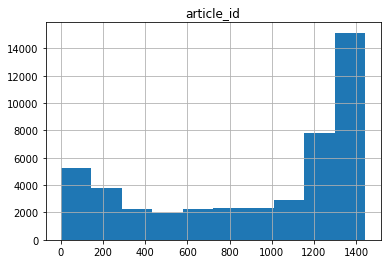

In [11]:
# Let's plot an histogram of the df dataset
# --> We can see clearly that there are articles more interesting than others...
df.hist()

In [12]:
# Let's see how many users have consulted some article
n_interactions = df.email.value_counts()

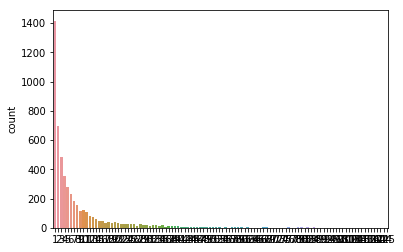

In [13]:
#Lets visualize n_interactions distribution 
sns.countplot(x=n_interactions.values[10:], data=df)

In [14]:
df.groupby(["article_id","email"]).count()

title
article_id email                                          
0.0        2841916b462a2b89d36f4f95ca2d1f42559a5788      1
           384255292a8223e84f05ca1e1deaa450c993e148      3
           451a9a4a4cb1cc4e5f38d04e8859cc3fb275cc66      1
           74ca1ae8b034f7fad73a54d55fb1f58747f00493      1
           8bd0afc488016810c287ac4ec844895d570b0af4      1
           a60b7e945a8f2114d5dfbdd53182ad1d526534e2      1
           ad06c765d31179e56f309438367ecb30e1059620      1
           ca7d48adf2c7394ed5a8776de959fa8047e43d4b      1
           db8ac9b2f552db35750239ada8bfcb59b3ae48c0      1
           df722d3aac72766b93d4a65d8b4ac084a968d684      1
           e667c9a1cd56368dfa2f4b974ab2d848585552d7      1
           e6ed9e15addba353fe3c1f36d865a63fa254b9cc      1
2.0        0246d11c827f90850ce7062e9554c9d5eeb30027      1
           0286bfe26356436658cf4b29b232f0700f0bb9ce      2
           12815feeacc6f27dff5b3441a54418d2d51001ef      1
           12bb8a9740400ced27ae5a7d4c990ac3b7e3c77d      1
           15a1660b6450e064200f1272d9b3d049cf8cf5f1      1
           1d74fc07ef225ff993b9f80dfba85a6bd2bd55b8      1
           249d60fc4edda28cd8fd76f549ecc43259e07038      1
           26b8f921fac7a4d81f2749d64c10020491281545      1
           2b6c0f514c2f2b04ad3c4583407dccd0810469ee      3
           2f5c7feae533ce046f2cb16fb3a29fe00528ed66      1
           3427a5a4065625363e28ac8e85a57a9436010e9c      3
           387f29d1e6f4360fa1a2c9607edfa184520bd716      1
           3e9be703aad3a99412af09cdefcdf28fe5ff2a32      1
           40222b846f3cef9a645dfb34fc15f7c1c244e393      1
           40a942b88fbc6b891eb335e12fbc589870098153      1
           449235d86e9d80f808112130da55d08bfb41703d      1
           4594c0796c9f32915d3f5c05c2cc5378ffcd40b4      1
           497935037e41a94d2ae02488d098c7abda9a30bc      1
...                                                    ...
1440.0     a4ce0a47da79499778f8cf4c94fd5cd0fde39002      1
           aaaf1a153d6b2f025b275c68324b6dd6d15f22ff      2
           e685741240520687a02b033e21938ddf3acdab7f      2
1441.0     3c3b60c3fb094373d6aa9420b2f8c08cd6a23354      1
           3cdbb321cad01f39848fcde8288109a73ee7febb      2
           436337957e43e0b1db33a58e87971319214d03a9      2
           6cce7568da5452718e1a3702edffac34a8da74ec      1
           8c37a3959fb30f349adff02cc545907dafd41b2a      1
           d5843ed71361c87b364f578f20a48101289d60f9      1
1442.0     0bd8ddb0c5cec4623a6bb663592747ad55477680      1
           21026417853cd181c161ae20651318978bf177b0      1
           5ad53e0336bcd4aef788745048a451f9c383bf81      1
           66fd330648798030d5fe39b4ea5b8f61e618eb6e      1
1443.0     32c368e390424c9326f736d32725e1e167abcbe4      2
           3d840ffab77365a1b2e5ccd464bd439a347d6105      1
           4ac1eb6a4d2dfbd4e18042c0908de9d3dd7c39b0      2
           4accff186b3c4fb061b11ad6ae1920556bd68382      2
           6cce7568da5452718e1a3702edffac34a8da74ec      1
           8a7982ea3a9d4fe4fd7389e0a94a539ccc81a7bc      1
           9676b33c28cfc8f8dea534ebfd26ec140f8e442f      5
           c20e17b171ff2a34b4d684b4fe3af3be7e0700f3      2
           d53071c9f495307a7a2b9d3619f7ec6e8721e1b7      1
           d5843ed71361c87b364f578f20a48101289d60f9      1
           ecee962fad63a7828319b3aa0a6557f94fc5691e      1
           fa19d1470e496ac4a7bd0eeb07d17b2b3a2f9e30      3
1444.0     6cce7568da5452718e1a3702edffac34a8da74ec      1
           c45f9495a76bf95d2633444817f1be8205ad542d      1
           d313c83ab3ed388ba16042a6cd33fce57d6a9e9a      1
           d5843ed71361c87b364f578f20a48101289d60f9      1
           fd824fc62b4753107e3db7704cd9e8a4a1c961f1      1

[33669 rows x 1 columns]

In [15]:
mydf = df.groupby(["email"])
print(mydf)

In [16]:
mydf.describe()

article_id                           \
                                              count         mean         std   
email                                                                          
0000b6387a0366322d7fbfc6434af145adf7fed1       13.0   674.538462  537.898475   
001055fc0bb67f71e8fa17002342b256a30254cd        4.0   538.500000  575.343086   
00148e4911c7e04eeff8def7bbbdaf1c59c2c621        3.0   858.666667  567.564387   
001a852ecbd6cc12ab77a785efa137b2646505fe        6.0   809.833333  495.809406   
001fc95b90da5c3cb12c501d201a915e4f093290        2.0   871.500000  696.500179   
0042719415c4fca7d30bd2d4e9d17c5fc570de13        2.0   540.000000  735.391052   
00772abe2d0b269b2336fc27f0f4d7cb1d2b65d7        3.0  1195.333333  401.258437   
008ba1d5b4ebf54babf516a2d5aa43e184865da5       10.0  1077.000000  394.747176   
008ca24b82c41d513b3799d09ae276d37f92ce72        1.0   146.000000         NaN   
008dfc7a327b5186244caec48e0ab61610a0c660       13.0   663.307692  486.963275   
009af4e0537378bf8e8caf0ad0e2994f954d822e        1.0  1299.000000         NaN   
00bda305223d05f6df5d77de41abd2a0c7d895fe        4.0  1041.000000  332.859330   
00c2d5190e8c6b821b0e3848bf56f6e47e428994        3.0   423.333333  221.590463   
00ced21f957bbcee5edf7b107b2bd05628b04774        4.0   590.250000  454.642992   
00d9337ecd5f70fba1c4c7a78e21b3532e0112c4        3.0   241.000000    0.000000   
00e524e4f13137a6fac54f9c71d7769c6507ecde       11.0   953.545455  533.066293   
00f8341cbecd6af00ba8c78b3bb6ec49adf83248        3.0   893.333333  766.721157   
00f946b14100f0605fa25089437ee9486378872c        1.0  1364.000000         NaN   
01041260c97ab9221d923b0a2c525437f148d589        2.0  1424.000000    8.485281   
0108ce3220657a9a89a85bdec959b0f2976dd51c        4.0  1327.500000   76.019734   
011455e91a24c1fb815a4deac6b6eaf5ad16819e        9.0   903.888889  583.737836   
01198c58d684d79c9026abe355cfb532cb524dc5        1.0  1183.000000         NaN   
011ae4de07ffb332b0f51c155a35c23c80294962       35.0   854.685714  472.957949   
011fcfb582be9534e9a275336f7e7c3717100381       11.0  1238.272727  410.745686   
0129dfcdb701b6e1d309934be6393004c6683a2d       15.0  1015.533333  547.825424   
01327bbc4fd7bfe8ad62e599453d2876b928e725        3.0   686.666667  685.219186   
01455f0ab0a5a22a93d94ad35f6e78431aa90625        7.0   707.000000  212.370745   
014dedab269f1453c647598c92a3fa37b39eed97        2.0   646.000000  726.905771   
014e4fe6e6c5eb3fe5ca0b16c16fb4599df6375c        1.0    12.000000         NaN   
01560f88312a91894d254e6406c25df19f0ad5e8       11.0   924.454545  432.383248   
...                                             ...          ...         ...   
fe5396e3762c36767c9c915f7ed1731691d7e4b4        1.0   910.000000         NaN   
fe5480ff15f0ac51eeb2314a192351f168d7aad7        1.0   600.000000         NaN   
fe56a49b62752708ed2f6e30677c57881f7b78d1       15.0  1010.266667  480.582008   
fe5885b80e91be887510a0b6dd04e011178d6364        3.0  1213.000000  239.539141   
fe5f9d7528518e00b0a73c7a3994afc335496961        3.0  1133.333333  160.855007   
fe66aa534c7824eca663b84b99a437a98a9b026e        2.0  1127.000000  427.092496   
fe69c72c964a8346dbc7763309c4e07d818d360f        4.0  1249.750000   52.500000   
fe88d1f683f308b32fb3d7554f007cc55cc48df5        1.0   390.000000         NaN   
fe8c1cb974e39d8ea8c005044e927b3f0de8acd0        3.0  1027.333333  463.612266   
fe90d98b0287090fe8e653bafba6ed3eff19331e        1.0   162.000000         NaN   
fe9327be39fd457df70e83d3fc8cba9b8b3f95b1        1.0   213.000000         NaN   
feaea388105a4ccc48795b191bbf0c26a23b1356        4.0   502.500000  257.942500   
fef0c6be3a2ed226e1fb8a811b0ee68a389f6f3c       13.0   368.384615  294.231637   
fef28e45f7217026b2684d1783a2e18b061bdffb        3.0   424.333333  255.684050   
fef3bc88def1aa787c99957ded7d5b2c0edc040e        4.0  1275.000000  236.668545   
ff27ffd93e21154b8a9cf2722f2cc0f75dc39eff        1.0  1420.000000         NaN   
ff288722b76eba5209cdbf9158c6dfbf229b9129 

In [17]:
df[df['email'].duplicated()]

,article_id,title,email
13,1314.0,healthcare python streaming application demo,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
14,1170.0,"apache spark lab, part 1: basic concepts",35d5799b6ea3ba24f921ed38f7f9a8039ad06ba4
16,12.0,timeseries data analysis of iot events by usin...,fc4e4290f2f320d80711bbe019618cc5be8815fa
23,1052.0,access db2 warehouse on cloud and db2 with python,f44787ebd5330e097a1ee8aea81d970200e912bb
24,1432.0,visualize data with the matplotlib library,f0d738c18e8ef4736beabea9db813cd86cc5a148
26,1338.0,ml optimization using cognitive assistant,b32cd4e1a74e55ac42e4ef484b1f0ad41ee3b1c5
30,194.0,data science for real-time streaming analytics,b32cd4e1a74e55ac42e4ef484b1f0ad41ee3b1c5
32,1324.0,ibm watson facebook posts for 2015,3b241403886ff0b565c4c00bbe5f86647ece0a92
34,1052.0,access db2 warehouse on cloud and db2 with python,3bbca9c41c66c4ecc46bc14eac7b7ab1ab0a5bea
36,1432.0,visualize data with the matplotlib library,ec123f6658890db92d7db29a04c03e5e2098fa43


In [18]:
#Lets see what are the articles_id visits
articles_visits = df.article_id.value_counts()

In [19]:
top_articles = list(df["title"].value_counts().head(10).index)
top_articles

['use deep learning for image classification',
 'insights from new york car accident reports',
 'visualize car data with brunel',
 'use xgboost, scikit-learn & ibm watson machine learning apis',
 'predicting churn with the spss random tree algorithm',
 'healthcare python streaming application demo',
 'finding optimal locations of new store using decision optimization',
 'apache spark lab, part 1: basic concepts',
 'analyze energy consumption in buildings',
 'gosales transactions for logistic regression model']

In [20]:
top_users = list(df["email"].value_counts().head(10).index)
top_users

['2b6c0f514c2f2b04ad3c4583407dccd0810469ee',
 '77959baaa9895a7e2bdc9297f8b27c1b6f2cb52a',
 '2f5c7feae533ce046f2cb16fb3a29fe00528ed66',
 'a37adec71b667b297ed2440a9ff7dad427c7ac85',
 '8510a5010a5d4c89f5b07baac6de80cd12cfaf93',
 'f8c978bcf2ae2fb8885814a9b85ffef2f54c3c76',
 '284d0c17905de71e209b376e3309c0b08134f7e2',
 'd9032ff68d0fd45dfd18c0c5f7324619bb55362c',
 '18e7255ee311d4bd78f5993a9f09538e459e3fcc',
 '276d9d8ca0bf52c780b5a3fc554fa69e74f934a3']

In [21]:
df['article_id'].value_counts().head(3)

1429.0    937
1330.0    927
1431.0    671
Name: article_id, dtype: int64

### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [22]:
articles_by_user = df.groupby('email')['article_id'].count()

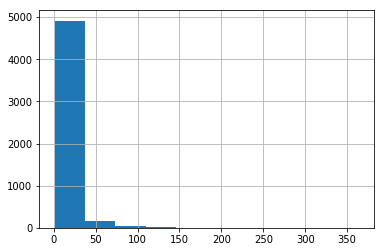

In [23]:
articles_by_user.hist()

In [24]:
articles_by_user.describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_id, dtype: float64

In [25]:
articles_by_user.median()

3.0

In [26]:
articles_by_user.max()

364

In [27]:
# Fill in the median and maximum number of user_article interactios below
median_val = articles_by_user.median()# 50% of individuals interact with 3 number of articles or fewer.
max_views_by_user = articles_by_user.max()# The maximum number of user-article interactions by any 1 user is 364.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [28]:
df_content

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4
5,Compose is all about immediacy. You want a new...,Using Compose's PostgreSQL data browser.,Browsing PostgreSQL Data with Compose,Live,5
6,UPGRADING YOUR POSTGRESQL TO 9.5Share on Twitt...,Upgrading your PostgreSQL deployment to versio...,Upgrading your PostgreSQL to 9.5,Live,6
7,Follow Sign in / Sign up 135 8 * Share\r\n * 1...,For a company like Slack that strives to be as...,Data Wrangling at Slack,Live,7
8,* Host\r\n * Competitions\r\n * Datasets\r\n *...,Kaggle is your home for data science. Learn ne...,Data Science Bowl 2017,Live,8
9,THE GRADIENT FLOW\r\nDATA / TECHNOLOGY / CULTU...,[A version of this post appears on the O’Reill...,Using Apache Spark to predict attack vectors a...,Live,9


In [29]:
df_content[df_content['article_id'].duplicated()] # there are 5 duplicated rows

,doc_body,doc_description,doc_full_name,doc_status,article_id
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [30]:
# Remove any rows that have the same article_id (only keep the first one, the original)
df_content = df_content.drop_duplicates(subset=['article_id'])

In [31]:
# Let's check if we have deleted the duplicates, the original length was 1056 and there is 5 duplicated 1056-5 = 1051

In [32]:
len (df_content)

1051

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [33]:
n_unique_articles_interact = df['article_id'].nunique()
print ("a. The number of unique articles that have an interaction with a user is ",n_unique_articles_interact)

a. The number of unique articles that have an interaction with a user is  714


In [34]:
n_unique_articles = df_content["article_id"].nunique()
print ("b. The number of unique articles that have an interaction with a user is ",n_unique_articles)

b. The number of unique articles that have an interaction with a user is  1051


In [35]:
n_unique_users = df['email'].nunique()
print ("c. The number of unique users in the dataset is ",n_unique_users)

c. The number of unique users in the dataset is  5148


In [36]:
n_user_article = len(df)
print ("d. The number of user-article interactions in the dataset ",n_user_article)

d. The number of user-article interactions in the dataset  45993


In [37]:
unique_articles = n_unique_articles_interact# The number of unique articles that have at least one interaction
total_articles = n_unique_articles# The number of unique articles on the IBM platform
unique_users = n_unique_users# The number of unique users
user_article_interactions = n_user_article# The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [38]:
most_viewed_article_id = df["article_id"].value_counts()
most_viewed = most_viewed_article_id.head(1).index[0]
most_viewed

1429.0

In [39]:
most_viewed_article_id = str(most_viewed)# The most viewed article in the dataset as a string with one value following the decimal 
max_views = articles_visits.iloc[0]# The most viewed article in the dataset was viewed how many times?

In [40]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [41]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [42]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    top_articles = df["title"].value_counts().head(n).index
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    top_articles = df["article_id"].value_counts().head(n).index
 
    return top_articles # Return the top article ids

In [43]:
print(get_top_articles(10))
print(get_top_article_ids(10))

Index(['use deep learning for image classification',
       'insights from new york car accident reports',
       'visualize car data with brunel',
       'use xgboost, scikit-learn & ibm watson machine learning apis',
       'predicting churn with the spss random tree algorithm',
       'healthcare python streaming application demo',
       'finding optimal locations of new store using decision optimization',
       'apache spark lab, part 1: basic concepts',
       'analyze energy consumption in buildings',
       'gosales transactions for logistic regression model'],
      dtype='object')
Float64Index([1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0,
              1162.0, 1304.0],
             dtype='float64')


In [44]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [45]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    # We group by user_id and article_id, then apply value_counts() function to count the frecuency
    # after that we unstack to get the article_id as column and user_id as rows
    # and we apply fillna(0) to fill all the Nans values with a 0 
    user_item = df.groupby('user_id')['article_id'].value_counts().unstack().fillna(0)
    # finally we apply a filter to all the users that have read more that once an article, and change it by a 1
    # because we are asked to:
    # if a user has interacted with an article, then place a 1 where the user-row meets for that article-column. 
    user_item[user_item > 1]=1
        
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [46]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [47]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    most_similar_users = user_item.dot(user_item.loc[user_id])
    
    # sort by similarity
    most_similar_users = most_similar_users.sort_values(ascending=False)
    
    # create list of just the ids
    most_similar_users = most_similar_users.index
   
    # remove the own user's id
    most_similar_users = most_similar_users.drop(user_id)
    most_similar_users = list(most_similar_users)
       
    return (most_similar_users) # return a list of the users in order from most to least similar
        

In [48]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [49]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Your code here
    # eliminate unnecessary columns
    article_names = list(df[df["article_id"].isin(article_ids)]["title"].unique())
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # select the list of the articles_id that have been seen by the user, that is, that have a 1 on the matrix
    article_ids = list((user_item.iloc[user_id-1][user_item.iloc[user_id-1]==1].index).astype(str))
    # get the article names just calling the already defined function
    article_names = get_article_names(article_ids)

    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''

    # let's see the articles read by the user
    seen_articles_ids,seen_articles_names  = get_user_articles(user_id)
    similar_users = find_similar_users(user_id)
    
    recs = list()
    for user in similar_users:
        # find the articles_id and articles_name that has read a similar user
        new_article_id, new_article_name = get_user_articles(user)
        #
        new_recs = np.setdiff1d(seen_articles_ids, new_article_id, assume_unique=True)   
        recs.append(new_recs)
        recs = [item for sublist in recs for item in sublist]
     
        if len(recs)>=m:
            break
                    
    return recs[:m] # return your recommendations for this user_id    

In [50]:
user_user_recs(1, 10)

['1', '5', '1', '.', '0', '151.0', '268.0', '310.0', '329.0', '346.0']

In [51]:
get_article_names(user_user_recs(1, 10))

[]

In [52]:
# Test results of the previous funtions
# get the articles id and the corresponding titles that the user 2 has read
get_user_articles(2)

(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'],
 ['healthcare python streaming application demo',
  'use xgboost, scikit-learn & ibm watson machine learning apis',
  'gosales transactions for naive bayes model',
  'use r dataframes & ibm watson natural language understanding',
  'build a python app on the streaming analytics service',
  'using deep learning to reconstruct high-resolution audio'])

In [53]:
# Test results of the previous funtions
# get the articles titles of the articles that the user 2 has read
get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])

['healthcare python streaming application demo',
 'use xgboost, scikit-learn & ibm watson machine learning apis',
 'gosales transactions for naive bayes model',
 'use r dataframes & ibm watson natural language understanding',
 'build a python app on the streaming analytics service',
 'using deep learning to reconstruct high-resolution audio']

In [54]:
# Test results of the previous funtions
# find 10 articles the user 3 hasn't seen before and provides them as recommendations
user_user_recs(3, 10)

['20.0',
 '62.0',
 '116.0',
 '381.0',
 '681.0',
 '735.0',
 '784.0',
 '788.0',
 '868.0',
 '977.0']

In [55]:
# Test results of the previous funtions
#  find 10 articles names the user 3 hasn't seen before and provides them as recommendations
get_article_names(user_user_recs(3, 10))

['apache spark as the new engine of genomics',
 'quick guide to build a recommendation engine in python',
 'working interactively with rstudio and notebooks in dsx',
 'real-time sentiment analysis of twitter hashtags with spark (+ pixiedust)',
 'practical tutorial on random forest and parameter tuning in r',
 'how to write the first for loop in r',
 'a classification problem',
 'data visualization: the importance of excluding unnecessary details',
 '10 data science, machine learning and ai podcasts you must listen to',
 'making sense of the bias / variance trade-off in (deep) reinforcement learning']

In [56]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [57]:
df.head(5)

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [164]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
 
    # Initialize dataframe with proper columns
    neighbors_df = pd.DataFrame(columns=['neighbor_id','similarity','num_interactions'])
    
    # ---------------- find similar users ----------------    
    
    # first calculate the similarities (matrix dot)
    simms = np.dot(user_item, user_item.T)
    
    # eliminate the user_id from the neighbor matrix
    index=range(1, simms.shape[0]+1)
    user_simms=pd.DataFrame(simms, index=index, columns=index)
    user_simms=user_simms.loc[user_id]
    user_simms=user_simms.drop(user_id)
        
    # prepare neighbors_df dataframe
    neighbors_df.neighbor_id = user_simms.index
    neighbors_df.similarity =  user_simms
    neighbors_df.index = user_simms.index
    neighbors_df.num_interactions = df.groupby('user_id').count().sort_values('title',ascending=False).drop(user_id)
                              
    # sort by similarity and number of interactions descending and save this sorting into the dataframe
    neighbors_df = neighbors_df.sort_values(by=['similarity','num_interactions'],ascending=[False, False])
        
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
   
    # find the top articles
    top_articles = get_top_article_ids(m)
    # find the articles read by user
    articles_ids_read_by_user, articles_names_read_by_user  = get_user_articles(user_id)   
    #articles_ids_read_by_user = articles_ids_read_by_user.astype(np.float)
    # find similar users based on articles read by user  
    neighbors = get_top_sorted_users (user_id, user_item=user_item)

    recs = []
    for neigh in neighbors['neighbor_id']:
       
        if len(recs)<m:
            # get articles read by similar users -neighbors-            
            art_id = get_user_articles(neigh)[0]
     
            # detect the articles that have not been read by our user
            dif_art = np.setdiff1d(art_id, articles_ids_read_by_user, assume_unique=True)
            dif_art = np.intersect1d(top_articles,dif_art)
            #print (dif_art)
      
            recs = np.append(recs,dif_art)
            recs = np.unique(recs)        
            
        else:
            break
            
    recs = recs[:m]
    rec_names = get_article_names(recs)
    
    
    return recs, rec_names

In [165]:
rec_ids, rec_names = user_user_recs_part2(20, 10)

In [166]:
rec_ids

array(['1162.0', '1170.0', '1293.0', '1304.0', '1314.0', '1330.0',
       '1364.0', '1427.0', '1429.0', '1431.0'], 
      dtype='<U32')

In [167]:
rec_names

['healthcare python streaming application demo',
 'use deep learning for image classification',
 'apache spark lab, part 1: basic concepts',
 'predicting churn with the spss random tree algorithm',
 'analyze energy consumption in buildings',
 'visualize car data with brunel',
 'use xgboost, scikit-learn & ibm watson machine learning apis',
 'gosales transactions for logistic regression model',
 'insights from new york car accident reports',
 'finding optimal locations of new store using decision optimization']

In [168]:
get_top_sorted_users(131).head(n=10)

,neighbor_id,similarity,num_interactions
3872,3872,74.0,5
3784,3784,39.0,94
24,24,38.0,30
205,205,33.0,26
4461,4461,33.0,2
50,50,29.0,8
3766,3766,29.0,2
99,99,29.0,1
3699,3699,29.0,1
244,244,25.0,23


In [169]:
get_top_sorted_users(1).head()

,neighbor_id,similarity,num_interactions
3935,3935,35.0,5
3784,3784,17.0,94
25,25,17.0,10
205,205,15.0,26
4461,4461,15.0,2


In [152]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1162.0' '1170.0' '1293.0' '1304.0' '1314.0' '1330.0' '1364.0' '1427.0'
 '1429.0' '1431.0']

The top 10 recommendations for user 20 are the following article names:
['healthcare python streaming application demo', 'use deep learning for image classification', 'apache spark lab, part 1: basic concepts', 'predicting churn with the spss random tree algorithm', 'analyze energy consumption in buildings', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'finding optimal locations of new store using decision optimization']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [153]:
neighbor1 = get_top_sorted_users(1)['neighbor_id'].iloc[0]

In [154]:
neighbor1

3935

In [155]:
neighbor2 = get_top_sorted_users(131)['neighbor_id'].iloc[9]
neighbor2

244

In [156]:
### Tests with a dictionary of results

user1_most_sim = neighbor1# Find the user that is most similar to user 1 
user131_10th_sim =neighbor2 # Find the 10th most similar user to user 131

In [157]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

TypeError: 'numpy.int64' object is not iterable

`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Provide your response here.**
Answer: For a new user, as we don't have information about him/her, we could offer some articles from the get_top_articles function, as those are the most read articles by the rest of the users. Another option would be apply some knowledge based function, if we have some information of the user

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [70]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10)# Your recommendations here
new_user_recs = [str(i) for i in new_user_recs]

In [71]:
new_user_recs 

['1429.0',
 '1330.0',
 '1431.0',
 '1427.0',
 '1364.0',
 '1314.0',
 '1293.0',
 '1170.0',
 '1162.0',
 '1304.0']

In [72]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [73]:
df_content.head(5)

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [ ]:
def make_content_recs():
    '''
    INPUT:
    
    OUTPUT:
    
    '''

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [ ]:
# make recommendations for a brand new user


# make a recommendations for a user who only has interacted with article id '1427.0'



### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [257]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [258]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [259]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix) # use the built in to get the three matrices

**Provide your response here.**

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

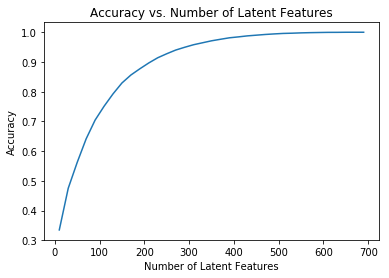

In [260]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [170]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # create the user item matrix with train df
    user_item_train = create_user_item_matrix(df_train)
    # create the user item matrix with the test df 
    user_item_test = create_user_item_matrix(df_test)
    
    # get the user_ids of the test set
    test_idx = user_item_test.index.values
    # get the articles_ids of the test set
    test_arts = user_item_test.columns.values
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [171]:
# How many users can we make predictions for in the test set
# Let's see how many users are in the test set and also in the train set

users_for_prediction = len(np.intersect1d(user_item_train.index.values,test_idx))
users_for_prediction

20

In [172]:
# How many users in the test set are we not able to make predictions for because of the cold start problem?
# Let's see how many users are in the test set (those would be the total of predictions) and rest them the number of 
# users that we can predict
users_not_for_prediction = len(test_idx) - users_for_prediction
users_not_for_prediction

662

In [173]:
# How many movies (in fact they are articles) can we make predictions for in the test set
# let's see the articles that are both on the training and test sets
common_articles = np.intersect1d(df_train.article_id.unique(),df_test.article_id.unique())
len(common_articles)

574

In [174]:
# How many movies in the test set are we not able to make predictions for because of the cold start problem?
# Let's see how many articles are in the test_arts and rest the number of articles that are common on both sets (train and test)
common_articles_cold = len(test_arts) - len(common_articles)
common_articles_cold

0

In [175]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?':c, # letter here, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?':a, # letter here, 
    'How many movies can we make predictions for in the test set?':b, # letter here,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?':d # letter here
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [179]:
# TRAIN SET
train_user_id = user_item_train.index
train_article_id = user_item_train.columns

# TEST SET
# it's the information that is contained in the train set and also in the test set
user_item_train, user_item_test, test_idx, test_arts
test_user_id = np.intersect1d(train_user_id, test_idx)
test_article_id =  np.intersect1d(train_article_id, test_arts)

In [180]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train) # fit svd similar to above then use the cells below

In [ ]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Your response here.**

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])